### Process the images in preparation for training or prediction
F. Burkholder 26 Sept. 2017

In [1]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_car_ids(txtfile):
    ids = np.loadtxt(txtfile, dtype='string_')
    
    # change byte literals to strings
    def to_str(x):
        return x.decode('UTF-8')
    to_str = np.vectorize(to_str)
    
    return to_str(ids)

In [3]:
fname = 'ids_train.txt'
ids = get_car_ids(fname)
print("There are {0} cars in {1}.".format(ids.shape[0], fname))
print("The first five cars are {0}".format(ids[:5]))

There are 254 cars in ids_train.txt.
The first five cars are ['78f63d808555' 'd46244bc42ed' '3c6acfceb552' '78bfb9c780db' '82f72273d23e']


In [4]:
def get_img_fnames_for_car_id(car_id, folder, ext):
    views = ['_0'+ str(num) for num in range(1,10)]
    views.extend(['_' + str(num) for num in range(10, 17)])
    img_fnames = [folder + car_id + view + ext for view in views]
    return img_fnames

In [5]:
car_id = ids[10]
folder = 'train/'
ext = '.jpg'
car_fname_imgs = get_img_fnames_for_car_id(car_id, folder, ext)
folder = 'train_masks/'
ext = '_mask.gif'
car_fname_masks = get_img_fnames_for_car_id(car_id, folder, ext)

In [6]:
fname = car_fname_imgs[0]
img = io.imread(fname)
fname.split('.')[1]

'jpg'

In [7]:
def get_cropped_imgs_from_fname(fname, crop_row, crop_col, crop_win):
    img_full = io.imread(fname)
    ht = img_full.shape[0]
    wd = img_full.shape[1]
    if fname.split('.')[1] == 'gif':
        is_mask = True
        img = img_full[crop_row:ht - crop_row, crop_col:wd - crop_col]
    else:
        is_mask = False
        img = img_full[crop_row:ht - crop_row, crop_col:wd - crop_col, :]

    ht_c = img.shape[0]
    wd_c = img.shape[1]
    num_row = ht_c / crop_win
    assert (num_row==5), 'Image incorrect size' # was 6 for 212
    num_col = wd_c / crop_win
    assert (num_col==7), 'Image incorrect size' # was 9 for 212
    num_cimgs = int(num_row * num_col)

    if is_mask:
        cimgs = np.zeros((num_cimgs, crop_win, crop_win), dtype = 'uint8')
    else:
        cimgs = np.zeros((num_cimgs, crop_win, crop_win, img.shape[2]), dtype = 'uint8')

    for i in range(num_cimgs):
        r = int(i // num_col)
        c = int(i - r * num_col)
        rl = int(r * crop_win)
        ru = int(rl + crop_win)
        cl = int(c * crop_win)
        cu = int(cl + crop_win)
        if is_mask:
            cimgs[i] = img[rl:ru, cl:cu]
        else:
            cimgs[i] = img[rl:ru, cl:cu, :]
    return cimgs

In [8]:
car_index = 0 # 0 to 253
fname_img = car_fname_imgs[car_index]
fname_mask = car_fname_masks[car_index]
crop_row = 0 # was 4 for 212
crop_col = 63 # was 5 for 212
crop_win = 256 # was 212
cropped_imgs = get_cropped_imgs_from_fname(fname_img, crop_row, crop_col, crop_win)
cropped_masks = get_cropped_imgs_from_fname(fname_mask, crop_row, crop_col, crop_win)
print("Image array shapes {0}".format(cropped_imgs.shape))
print("Mask array shapes {0}".format(cropped_masks.shape))

Image array shapes (35, 256, 256, 3)
Mask array shapes (35, 256, 256)


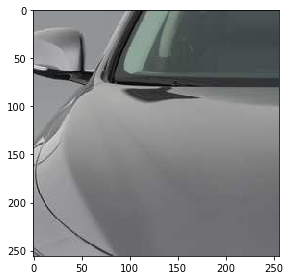

In [9]:
i = 16
io.imshow(cropped_imgs[i])

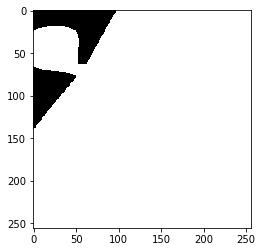

In [10]:
i = 16
plt.imshow(cropped_masks[i], vmin=0, vmax=255, cmap='gray')

In [11]:
def make_1_channel_into_3_channel_img(img_1_chan):
    img_3_channel = np.zeros((img_1_chan.shape[0], img_1_chan.shape[1], 3), dtype = 'uint8')
    img_3_channel[:,:,0] = img_1_chan
    img_3_channel[:,:,1] = img_1_chan
    img_3_channel[:,:,2] = img_1_chan
    return img_3_channel

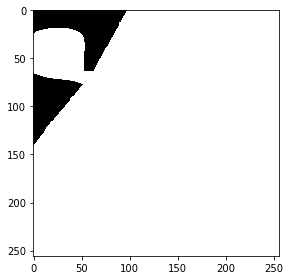

In [12]:
i = 16
mask_3_channel = make_1_channel_into_3_channel_img(cropped_masks[i])
io.imshow(mask_3_channel)

In [57]:
def stich_two_imgs_together(img1, img2):
    assert (img1.shape[0] == img2.shape[0]), 'Images are not the same height'
    lw_bk = 2
    lw_wt = 20
    vline_bk = np.zeros((img1.shape[0], lw_bk, img1.shape[2]), dtype = 'uint8')
    vline_wt = np.ones((img1.shape[0], lw_wt, img1.shape[2]), dtype = 'uint8') * 255
    img = np.hstack((img1, vline_bk))
    img = np.hstack((img, vline_wt))
    img = np.hstack((img, vline_bk))
    img = np.hstack((img, img2))
    return img

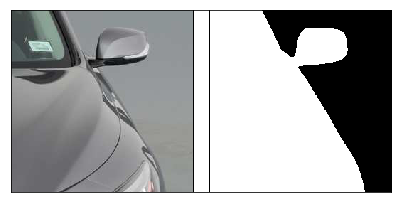

In [50]:
i = 18
mask_3_chan = make_1_channel_into_3_channel_img(cropped_masks[i])
stiched = stich_two_imgs_together(cropped_imgs[i], mask_3_chan)
io.imshow(stiched)
plt.xticks([])
plt.yticks([])
plt.savefig(car_id + "_" + str(i) + '_.png' )

In [27]:
car_id

'0ee135a3cccc'

In [52]:
all_wins_set = set([18])
test_wins_set = set([16])
train_wins = sorted(list(all_wins_set - test_wins_set))
test_wins = sorted(list(test_wins_set))
print("The train windows are {0}.".format(train_wins))
print("The test windows are {0}".format(test_wins))

The train windows are [18].
The test windows are [16]


In [53]:
def make_labels(y, img_h, img_w, n_labels):
    ''' makes a column for each label in y'''
    def make_label_img(labels, img_h, img_w, n_labels):
        label_map = np.zeros([img_h, img_w, n_labels])    
        for r in range(img_h):
            for c in range(img_w):
                label_map[r, c, labels[r][c]] = 1
        return label_map

    labels_lst = []
    m = y.shape[0]
    for lbl in y:
        lbl_clp = np.clip(lbl, 0, 1)
        lbl_chans = make_label_img(lbl_clp, img_h, img_w, n_labels)
        labels_lst.append(lbl_chans)
    labels = np.array(labels_lst).reshape((m, img_h * img_w, n_labels))
    return labels

In [55]:
# make the train set
win = train_wins
m = len(win)
data_arr = np.zeros((m, 3, crop_win, crop_win), dtype='uint8')
label_arr = np.zeros((m, crop_win, crop_win), dtype='uint8')
for i in range(m):
    data_arr[i] = cropped_imgs[win[i]].reshape((3, crop_win, crop_win))
    label_arr[i] = cropped_masks[win[i]]

print(data_arr.shape)
print(data_arr[0].shape)
print(label_arr.shape)
print(label_arr[0].shape)

n_labels = 2 # 2 classes - car or not
labels = make_labels(label_arr, crop_win, crop_win, n_labels)
print(labels.shape)

np.save('temp/X_train.npy', data_arr)
np.save('temp/y_train.npy', labels)

(1, 3, 256, 256)
(3, 256, 256)
(1, 256, 256)
(256, 256)
(1, 65536, 2)


In [60]:
# use this t0 make 8 versions of the train set
win = train_wins
m = len(win) * 8
data_arr = np.zeros((m, 3, crop_win, crop_win), dtype='uint8')
label_arr = np.zeros((m, crop_win, crop_win), dtype='uint8')

# images
imgs = []
base = cropped_imgs[win[0]]
imgs.append(base)
r1 = np.rot90(base, k=1)
imgs.append(r1)
r2 = np.rot90(base, k=2)
imgs.append(r2)
r3 = np.rot90(base, k=3)
imgs.append(r3)
f = np.fliplr(base)
imgs.append(f)
fr1 = np.rot90(f, k=1)
imgs.append(fr1)
fr2 = np.rot90(f, k=2)
imgs.append(fr2)
fr3 = np.rot90(f, k=3)
imgs.append(fr3)

# masks
masks = []
base_m = cropped_masks[win[0]]
masks.append(base_m)
r1_m = np.rot90(base_m, k=1)
masks.append(r1_m)
r2_m = np.rot90(base_m, k=2)
masks.append(r2_m)
r3_m = np.rot90(base_m, k=3)
masks.append(r3_m)
f_m = np.fliplr(base_m)
masks.append(f_m)
fr1_m = np.rot90(f_m, k=1)
masks.append(fr1_m)
fr2_m = np.rot90(f_m, k=2)
masks.append(fr2_m)
fr3_m = np.rot90(f_m, k=3)
masks.append(fr3_m)

for i in range(m):
    data_arr[i] = imgs[i].reshape((3, crop_win, crop_win))
    label_arr[i] = masks[i]

print(data_arr.shape)
print(data_arr[0].shape)
print(label_arr.shape)
print(label_arr[0].shape)

n_labels = 2 # 2 classes - car or not
labels = make_labels(label_arr, crop_win, crop_win, n_labels)
print(labels.shape)

np.save('temp/X_train.npy', data_arr)
np.save('temp/y_train.npy', labels)

(8, 3, 256, 256)
(3, 256, 256)
(8, 256, 256)
(256, 256)
(8, 65536, 2)


In [61]:
# make the test set
win = test_wins
m = len(win)
data_arr = np.zeros((m, 3, crop_win, crop_win), dtype='uint8')
label_arr = np.zeros((m, crop_win, crop_win), dtype='uint8')
for i in range(m):
    data_arr[i] = cropped_imgs[win[i]].reshape((3, crop_win, crop_win))
    label_arr[i] = cropped_masks[win[i]]

print(data_arr.shape)
print(data_arr[0].shape)
print(label_arr.shape)
print(label_arr[0].shape)

n_labels = 2 # 2 classes - car or not
labels = make_labels(label_arr, crop_win, crop_win, n_labels)
print(labels.shape)

np.save('temp/X_test.npy', data_arr)
np.save('temp/y_test.npy', labels)

(1, 3, 256, 256)
(3, 256, 256)
(1, 256, 256)
(256, 256)
(1, 65536, 2)


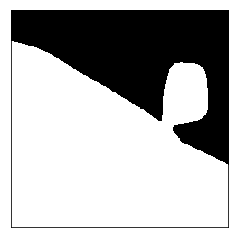

In [80]:
plt.imshow(masks[7], vmin=0, vmax=255, cmap='gray')
#plt.imshow(imgs[7]);
plt.xticks([])
plt.yticks([]);